# Introduction

* Python visualization of a graph with edges plotted as parabolic lines. The graph layout is made using [NetworkX layouts](https://networkx.org/documentation/stable/reference/drawing.html).

* By MGM, ORNL

* 2022 July 2022 (Original code for fungal graphs in 2020 August)

# Import libraries

In [1]:
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Functions

In [2]:
def getedge_selfloop(x1, y1):
    # limited implementation for a simple circular/rhombic arrangement of nodes
    radius = 0.1*np.max(np.abs(node_cor))
    theta = np.linspace(0, 2*np.pi, 100)
    # set dx & dy for shifting circle centers
    if np.abs(y1) < 1e-4:  # if node is on horizontal row
        dy = 0
        if x1 > 0: dx = radius     # if node is on right side, shift circle center to right
        elif x1 < 0: dx = -radius  # similar to above for left side
    else:                  # if node is on one of the vertical rows
        dx = 0
        if y1 > 0: dy = radius     # if node is on top row, shift circle center to top
        elif y1 < 0: dy = -radius  # similar to above for bottom row
    x_co = x1 + radius*np.sin(theta) + dx
    y_co = y1 + radius*np.cos(theta) + dy
    return x_co, y_co

def getedge(x_pts, y_pts, slp):
    # create parabolic lines between points
    # y = ax^2 + bx + c: y(1) and y(2) - 2 eqns.
    # y' = 2ax + b = slope of parabola: y'(1) - 1 eqn. 
    # take y'(1), y(1) and y(2) - solve 3 equations to obtain a,b,c
    A_p = np.array([[2*x_pts[0],    1,          0],
        [x_pts[0]**2,    x_pts[0],   1],
        [x_pts[1]**2,    x_pts[1],   1]]);
    B_p = np.array([ slp*1,        # slope of parabola changes sign alternatively
        y_pts[0],
        y_pts[1]]);
    C_p = np.linalg.solve(A_p, B_p);
    a = C_p[0]; b = C_p[1]; c = C_p[2]; # coefficients of parabola equation
    yp = lambda xp : a*xp**2 + b*xp + c
    x_co = np.linspace(x_pts[0], x_pts[1], 100);
    y_co = yp(x_co)
    return x_co, y_co

# Main

## User parameters and adjacency matrix

In [3]:
# Choose how many nodes in network
nnodes = 5
# Create a random Adjacency matrix (edge weights are between [0,1]). If not, normalize Adj.
Adj = np.random.rand(nnodes,nnodes)

######## Find coordinates of nodes
# use NetworkX layouts as a base
Gfull = nx.from_numpy_matrix(Adj, create_using=nx.DiGraph)
# change layout HERE
pos = nx.shell_layout(Gfull)
# get node positions from NetworkX layout
node_cor = np.zeros( (nnodes,2) )
for i in range(len(pos)):
    node_cor[i,:] = pos[i][:]
node_color = cm.get_cmap('gist_rainbow', nnodes)

## Plot graph

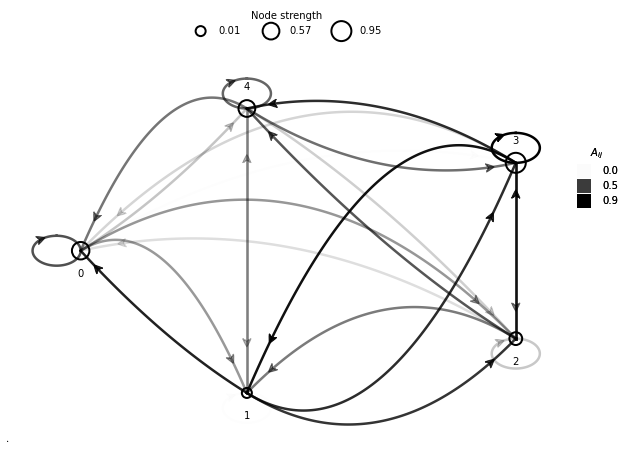

In [4]:
# ====================Start figure=========================
fig = plt.figure(figsize=[10, 7], facecolor="1")
ax2 = fig.add_subplot()

################# Plot nodes - size of node based on out-strength
color1 = 'black'       # node color
prop = Adj.diagonal(); # property for node size: out-strength
msizelg = [100,400]    # scaling (range) for nodes sizes
# compute node sizes
propsc = msizelg[0] + (prop-np.min(prop))*(msizelg[1]-msizelg[0])/(np.max(prop)-np.min(prop))

# plot nodes
scatr = ax2.scatter(node_cor[:,0], node_cor[:,1], edgecolors=color1, alpha=1, s=propsc, facecolors='none', linewidth=2)

# plot node number/ID
for j in range(nnodes):
    x_pts = node_cor[j,0]
    if node_cor[j,1]>0: y_pts = node_cor[j,1]+0.15 
    else: y_pts = node_cor[j,1]-0.15
    plt.text(x_pts, y_pts, str(j),
          ha='center', va='center', wrap=True)

# legend for node size
propsc = np.sort(propsc)
prop = np.sort(prop)
# add three representative node sizes
l1 = ax2.scatter([],[], edgecolors=color1, alpha=1, s=propsc[0], facecolors='none', linewidth=2)
l2 = ax2.scatter([],[], edgecolors=color1, alpha=1, s=propsc[int(len(prop)/2)], facecolors='none', linewidth=2)
l3 = ax2.scatter([],[], edgecolors=color1, alpha=1, s=propsc[-1], facecolors='none', linewidth=2)
# add text for these
strings = ["%0.2f" % i for i in prop]
labels = [strings[0], strings[int(len(prop)/2)], strings[-1]]
leg1 = ax2.legend([l1, l2, l3], labels, title="Node strength",
                 ncol=3, frameon=False, loc='center',bbox_to_anchor=(0.5, 1.1))
ax2.add_artist(leg1)

################# Plot edges
alph_max = np.max(abs(Adj))   # compute max edge weight for alpha of edges
for j in range(0,nnodes):
    for k in range(0,nnodes):
        if j == k:      # self-loop
            x_co, y_co = getedge_selfloop(node_cor[j,0],node_cor[j,1])
            
        elif j != k:    # all other edges
            x_pts = [ node_cor[j,0], node_cor[k,0] ];
            y_pts = [ node_cor[j,1], node_cor[k,1] ];
            # flip slopes of parabola for adjacent edges (change the conditions as per users requirement)
            if (j/2) == 0:
                slp = 1
            else:
                slp = -1
            # get parabolic line
            x_co, y_co  = getedge(x_pts, y_pts, slp)
        # set color & alpha of edge
        if Adj[j,k]>0: edg_col = 'black'
        elif Adj[j,k]<0: edg_col = 'tab:blue'
        alp = abs(Adj[j,k]) / alph_max
        # plot edge
        line = ax2.plot(x_co, y_co, color=edg_col, linewidth=2.5, alpha=alp)[0]
        # add arrow
        line.axes.annotate('',
            xytext=(x_co[90], y_co[90]),
            xy=(x_co[91], y_co[91]),
            arrowprops=dict(arrowstyle="fancy", color=edg_col, alpha=alp), size=20)

# legend for edge alpha
edges = abs(Adj.flatten()) / np.max(abs(Adj))
edges.sort()
edges = edges[np.nonzero(edges)]
# get three representative edge alphas
l1 = ax2.scatter([],[], marker='s', color='k', alpha=edges[0], s=200, edgecolors='none')
l2 = ax2.scatter([],[], marker='s', color='k', alpha=edges[int(len(edges)/2)], s=200, edgecolors='none')
l3 = ax2.scatter([],[], marker='s', color='k', alpha=edges[-1], s=200, edgecolors='none')
# add text for these
strings = ["%0.1f" % i for i in edges*np.max(abs(Adj))]
labels = [strings[0], strings[int(len(edges)/2)], strings[-1]]
leg3 = ax2.legend([l1, l2, l3], labels, title=r"$A_{ij}$",
                  frameon=False, loc='best',bbox_to_anchor=(1, 0.8))
ax2.add_artist(leg3)

# set the axis right
ax2.axis('tight')
ax2.axis('off');